# Analyzing Scenario Results

In [13]:
import pickle
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from src.configs.shocks import DEBT, LIQUIDITY, VOL, MU, JUMP, NEUTRAL, ADVERSE, SEVERE

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [412]:
def get_results(experiment_dir):
    """
    Get all the result objects in the result directory.
    """
    results = []
    parameter_dirs = [
        os.path.join(experiment_dir, f) for f in os.listdir(experiment_dir)
    ]
    for parameter_dir in parameter_dirs:
        if not os.path.isdir(parameter_dir):
            continue
        files = [os.path.join(parameter_dir, f) for f in os.listdir(parameter_dir)]
        for file in files:
            try:
                with open(file, "rb") as f:
                    result = pickle.load(f)
                results.append(result)
            except Exception as e:
                print(f"Error loading {file}: {e}")
    return results


def get_tags(result):
    shocks = result.metadata["template"].config["shocks"]
    tags = {
        MU: None,
        VOL: None,
        JUMP: None,
        DEBT: None,
        LIQUIDITY: None,
    }
    for shock in shocks:
        if shock["type"] == DEBT:
            tags[DEBT] = shock["tag"]
        elif shock["type"] == LIQUIDITY:
            tags[LIQUIDITY] = shock["tag"]
        elif shock["type"] == VOL:
            tags[VOL] = shock["tag"]
        elif shock["type"] == MU:
            tags[MU] = shock["tag"]
        elif shock["type"] == JUMP:
            tags[JUMP] = shock["tag"]

    for tag in tags:
        if tags[tag] is None:
            tags[tag] = NEUTRAL

    return tags


def get_active_debt_pct(result):
    active_debt_pcts = []
    for datum in result.data:
        active_debt = sum(datum.active_debt.values())
        initial_debt = sum(datum.initial_debt.values())
        active_debt_pcts.append(active_debt / initial_debt * 100)
    return active_debt_pcts


def compare(
    results,
    metrics=[
        "Bad Debt Pct",
        "Debt Liquidated Pct",
        "Net Llamma Profit Pct",
        "Soft Liquidation Loss Pct",
        "Borrower Loss Pct",
        "Worst Oracle Error Pct",
    ],
    include_lvr_metrics=False,
) -> pd.DataFrame:
    stats = []
    parameter = list(results[0].metadata["params"].keys())[0]
    for i, result in enumerate(results):
        starting_debt = (
            sum([datum.df["Total Debt"].iloc[0] for datum in result.data])
            / len(result.data)
            / 1e6
        )
        starting_crvusd_liquidity = (
            sum([datum.df["Total crvUSD Liquidity"].iloc[0] for datum in result.data])
            / len(result.data)
            / 1e6
        )

        param_val = list(result.metadata["params"].values())[0]
        if param_val > 1e14:
            # It's probs in ETH precision
            param_val /= 1e18

        stats_per_run = {
            "Name": result.metadata["template"].name,
            "Parameter": parameter,
            "Value": param_val,
            "Starting Debt (Mns)": starting_debt,
            "Total crvUSD Liquidity (Mns)": starting_crvusd_liquidity,
            "Starting Debt:Liquidity Ratio": starting_debt / starting_crvusd_liquidity,
        }

        tags = get_tags(result)
        stats_per_run.update(tags)

        for metric in metrics:
            stats_per_run[f"{metric} Mean"] = result.summary[f"{metric} Max"].mean()
            stats_per_run[f"{metric} Median"] = result.summary[f"{metric} Max"].median()
            stats_per_run[f"{metric} p99"] = result.summary[f"{metric} Max"].quantile(
                0.99
            )

        if include_lvr_metrics:
            stats_per_run["Pct of LVR Covered by Fees Mean"] = (
                result.summary["Net Llamma Profit Pct Max"]
                / result.summary["Soft Liquidation Loss Pct Max"]
                * 100
            ).mean()
            stats_per_run["Pct of LVR Covered by Fees Median"] = (
                result.summary["Net Llamma Profit Pct Max"]
                / result.summary["Soft Liquidation Loss Pct Max"]
                * 100
            ).median()
            # stats_per_run["Pct of LVR Covered by Fees p01"] = (
            #     result.summary["Net Llamma Profit Pct Max"]
            #     / result.summary["Soft Liquidation Loss Pct Max"]
            #     * 100
            # ).quantile(0.01)

            stats_per_run["Net LVR - Fees Pct Mean"] = (
                result.summary["Soft Liquidation Loss Pct Max"]
                - result.summary["Net Llamma Profit Pct Max"]
            ).mean()
            stats_per_run["Net LVR - Fees Pct Median"] = (
                result.summary["Soft Liquidation Loss Pct Max"]
                - result.summary["Net Llamma Profit Pct Max"]
            ).median()
            # stats_per_run["Net LVR - Fees Pct p01"] = (
            #     result.summary["Soft Liquidation Loss Pct Max"]
            #     - result.summary["Net Llamma Profit Pct Max"]
            # ).quantile(0.01)

            active_debt_pcts = get_active_debt_pct(result)
            stats_per_run["Active Debt Pct Mean"] = np.mean(active_debt_pcts)
            stats_per_run["Active Debt Pct Median"] = np.median(active_debt_pcts)

        stats.append(stats_per_run)

    df = pd.DataFrame(stats).astype(float, errors="ignore").round(5)
    df.sort_values(["Value", "Name"])
    return df


def annualize(daily_r):
    return ((1 + daily_r) ** 365 - 1) * 100

In [292]:
# results = get_results("../results/generic/no_sweep/")
# results = get_results("../results/chainlink_limits")
results = get_results("../results/debt_ceilings/")

In [446]:
df = compare(results)
df

,Name,Parameter,Value,Starting Debt (Mns),Total crvUSD Liquidity (Mns),Starting Debt:Liquidity Ratio,mu,vol,jump,debt,liquidity,Bad Debt Pct Mean,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Mean,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Net Llamma Profit Pct Mean,Net Llamma Profit Pct Median,Net Llamma Profit Pct p99,Soft Liquidation Loss Pct Mean,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Borrower Loss Pct Mean,Borrower Loss Pct Median,Borrower Loss Pct p99,Worst Oracle Error Pct Mean,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99
0,Severe vol and adverse growth,debt_ceiling,2.0,315.56659,142.08923,2.22090,neutral,severe,neutral,adverse,neutral,0.13292,0.00000,3.88616,2.99918,2.04873,19.17269,0.08403,0.06062,0.34698,0.10709,0.07809,0.44240,0.33774,0.23442,1.78699,0.12961,0.12632,0.16697
1,Baseline,debt_ceiling,2.0,216.91825,95.28715,2.27647,neutral,neutral,neutral,neutral,neutral,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00429,0.00202,0.02748,0.01161,0.00420,0.13623,0.01161,0.00420,0.13623,0.12295,0.12126,0.18272
2,Severe vol and severe growth,debt_ceiling,2.0,1104.78704,496.05392,2.22715,neutral,severe,neutral,severe,neutral,0.07460,0.01627,0.85753,3.26764,2.79368,10.29484,0.09416,0.08179,0.30246,0.11895,0.10347,0.37315,0.37520,0.33677,1.26332,0.12132,0.12113,0.16994
3,Severe vol,debt_ceiling,2.0,214.83981,95.60646,2.24713,neutral,severe,neutral,neutral,neutral,0.04505,0.00000,0.66658,2.33788,1.14520,14.82637,0.06873,0.04550,0.33490,0.08873,0.05537,0.41314,0.27073,0.14893,1.63985,0.12395,0.11957,0.18976
4,Adverse vol,debt_ceiling,2.0,216.62035,95.61007,2.26566,neutral,adverse,neutral,neutral,neutral,0.00669,0.00000,0.16680,0.81912,0.20365,9.30045,0.03967,0.02623,0.18783,0.04118,0.02479,0.23415,0.10426,0.04616,0.87801,0.16366,0.15588,0.22398
5,Severe vol and adverse growth,debt_ceiling,5.0,789.92895,355.27678,2.22342,neutral,severe,neutral,adverse,neutral,0.04454,0.00000,0.46588,2.79012,1.48858,13.60687,0.08254,0.05585,0.31532,0.10354,0.07149,0.39149,0.32008,0.20668,1.39838,0.13301,0.12864,0.17694
6,Baseline,debt_ceiling,5.0,542.26146,238.83573,2.27044,neutral,neutral,neutral,neutral,neutral,0.00004,0.00000,0.00000,0.00033,0.00000,0.00000,0.00433,0.00211,0.02868,0.01222,0.00460,0.15054,0.01224,0.00460,0.15054,0.12356,0.12165,0.16464
7,Severe vol and severe growth,debt_ceiling,5.0,2764.19818,1240.95657,2.22747,neutral,severe,neutral,severe,neutral,0.06105,0.01083,0.93314,3.17504,2.66381,10.56625,0.08706,0.07118,0.28846,0.11022,0.09772,0.32971,0.35880,0.31743,1.16836,0.12336,0.12162,0.17932
8,Severe vol,debt_ceiling,5.0,536.55145,239.29787,2.24219,neutral,severe,neutral,neutral,neutral,0.10044,0.00000,2.93660,2.73675,1.38966,13.67843,0.07352,0.04675,0.29778,0.09407,0.05776,0.38253,0.30405,0.16488,1.43500,0.12834,0.12507,0.18707
9,Adverse vol,debt_ceiling,5.0,542.26422,238.91517,2.26969,neutral,adverse,neutral,neutral,neutral,0.00698,0.00000,0.18372,0.57004,0.16962,5.92510,0.03280,0.02113,0.14709,0.03556,0.01993,0.16714,0.08161,0.03603,0.59600,0.21440,0.16229,0.24160


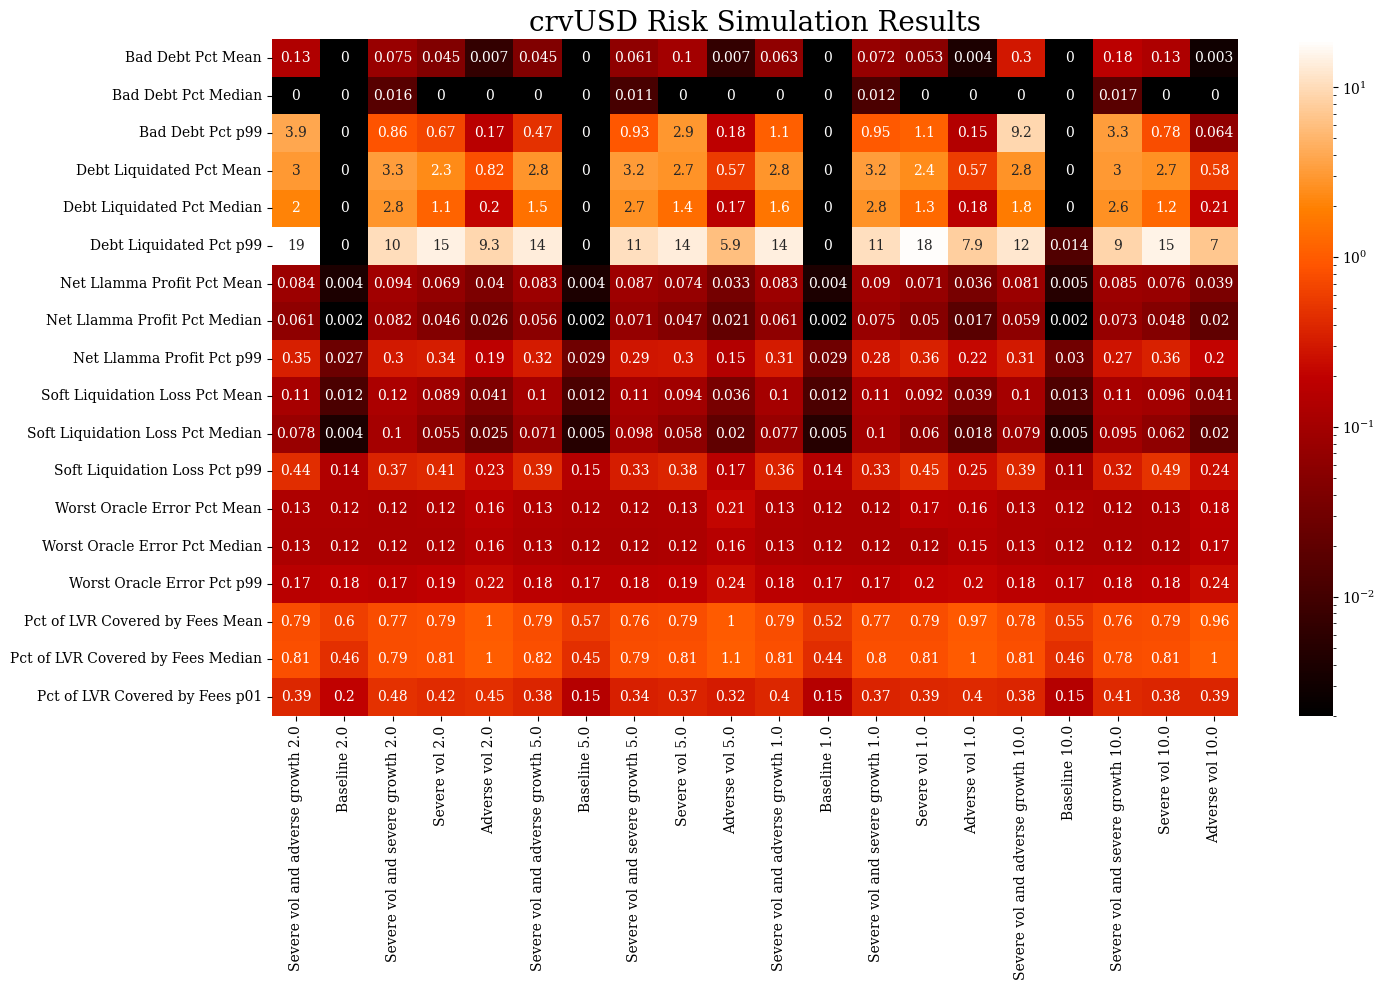

In [74]:
def make_heatmap(df, fn=None):
    # Create a heatmap
    plt.figure(figsize=(15, 10))
    mask = df.iloc[:, 11:].T.copy()
    # Create a new colormap with the adjusted colors
    cmap = plt.cm.gist_heat
    cmap.set_extremes(bad="black")
    fig = sns.heatmap(
        mask,
        annot=True,
        robust=True,
        xticklabels=df["Name"] + " " + df["Value"].astype(str),
        norm=mcolors.LogNorm(),
        cmap=cmap,
    )  # Assuming the first two columns are the indexes
    fig.set_title("crvUSD Generic Simulation Results", fontdict={"fontsize": 20})
    plt.tight_layout()
    if fn:
        plt.savefig(fn, dpi=300)
    plt.show()


make_heatmap(df, fn="../figs/results/chainlink_limits.png")

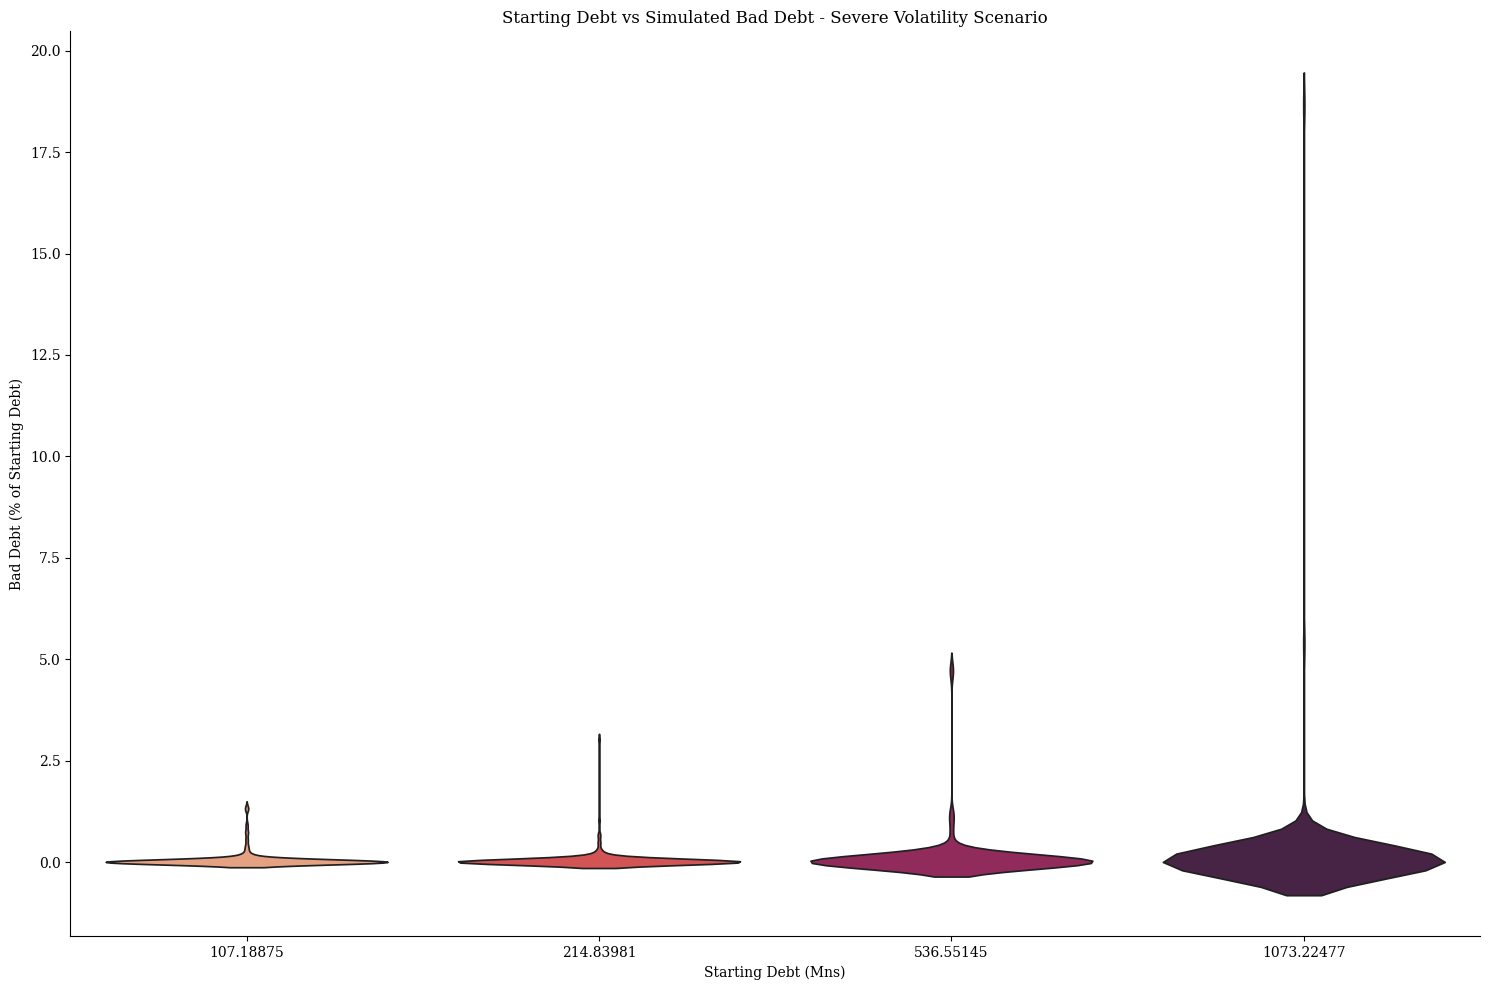

In [451]:
### Zoom in
ndf = df.copy()
shock_fixes = {
    VOL: SEVERE,
    # MU: NEUTRAL,
    # JUMP: NEUTRAL,
    # LIQUIDITY: ADVERSE,
    DEBT: NEUTRAL,
}
for col, tag in shock_fixes.items():
    ndf = ndf[ndf[col] == tag]
ndf.sort_values(["Starting Debt (Mns)"], inplace=True)

idxs = ndf.index
nresults = [results[i] for i in idxs]
labels = ndf["Starting Debt (Mns)"]

bad_debts = [nresult.summary["Bad Debt Pct Max"].tolist() for nresult in nresults]

plt.figure(figsize=(15, 10))
sns.violinplot(data=bad_debts, palette="rocket_r", inner=None)
plt.xlabel("Starting Debt (Mns)")
plt.xticks(range(len(labels)), labels)
plt.ylabel("Bad Debt (% of Starting Debt)")
plt.title("Starting Debt vs Simulated Bad Debt - Severe Volatility Scenario")
plt.tight_layout()
plt.savefig("../figs/results/bad_debt_vs_starting_debt.png", dpi=300)
plt.show()

In [452]:
ndf

,Name,Parameter,Value,Starting Debt (Mns),Total crvUSD Liquidity (Mns),Starting Debt:Liquidity Ratio,mu,vol,jump,debt,liquidity,Bad Debt Pct Mean,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Mean,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Net Llamma Profit Pct Mean,Net Llamma Profit Pct Median,Net Llamma Profit Pct p99,Soft Liquidation Loss Pct Mean,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Borrower Loss Pct Mean,Borrower Loss Pct Median,Borrower Loss Pct p99,Worst Oracle Error Pct Mean,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99
13,Severe vol,debt_ceiling,1.0,107.18875,47.84918,2.24014,neutral,severe,neutral,neutral,neutral,0.05252,0.0,1.12066,2.43236,1.26168,17.97042,0.07128,0.04992,0.35697,0.09180,0.05996,0.45387,0.28709,0.16937,2.02814,0.16773,0.12032,0.20034
3,Severe vol,debt_ceiling,2.0,214.83981,95.60646,2.24713,neutral,severe,neutral,neutral,neutral,0.04505,0.0,0.66658,2.33788,1.14520,14.82637,0.06873,0.04550,0.33490,0.08873,0.05537,0.41314,0.27073,0.14893,1.63985,0.12395,0.11957,0.18976
8,Severe vol,debt_ceiling,5.0,536.55145,239.29787,2.24219,neutral,severe,neutral,neutral,neutral,0.10044,0.0,2.93660,2.73675,1.38966,13.67843,0.07352,0.04675,0.29778,0.09407,0.05776,0.38253,0.30405,0.16488,1.43500,0.12834,0.12507,0.18707
18,Severe vol,debt_ceiling,10.0,1073.22477,478.50080,2.24289,neutral,severe,neutral,neutral,neutral,0.12848,0.0,0.77847,2.66989,1.25023,15.03956,0.07613,0.04811,0.35751,0.09574,0.06166,0.48921,0.30895,0.16543,1.60262,0.12633,0.12488,0.18423


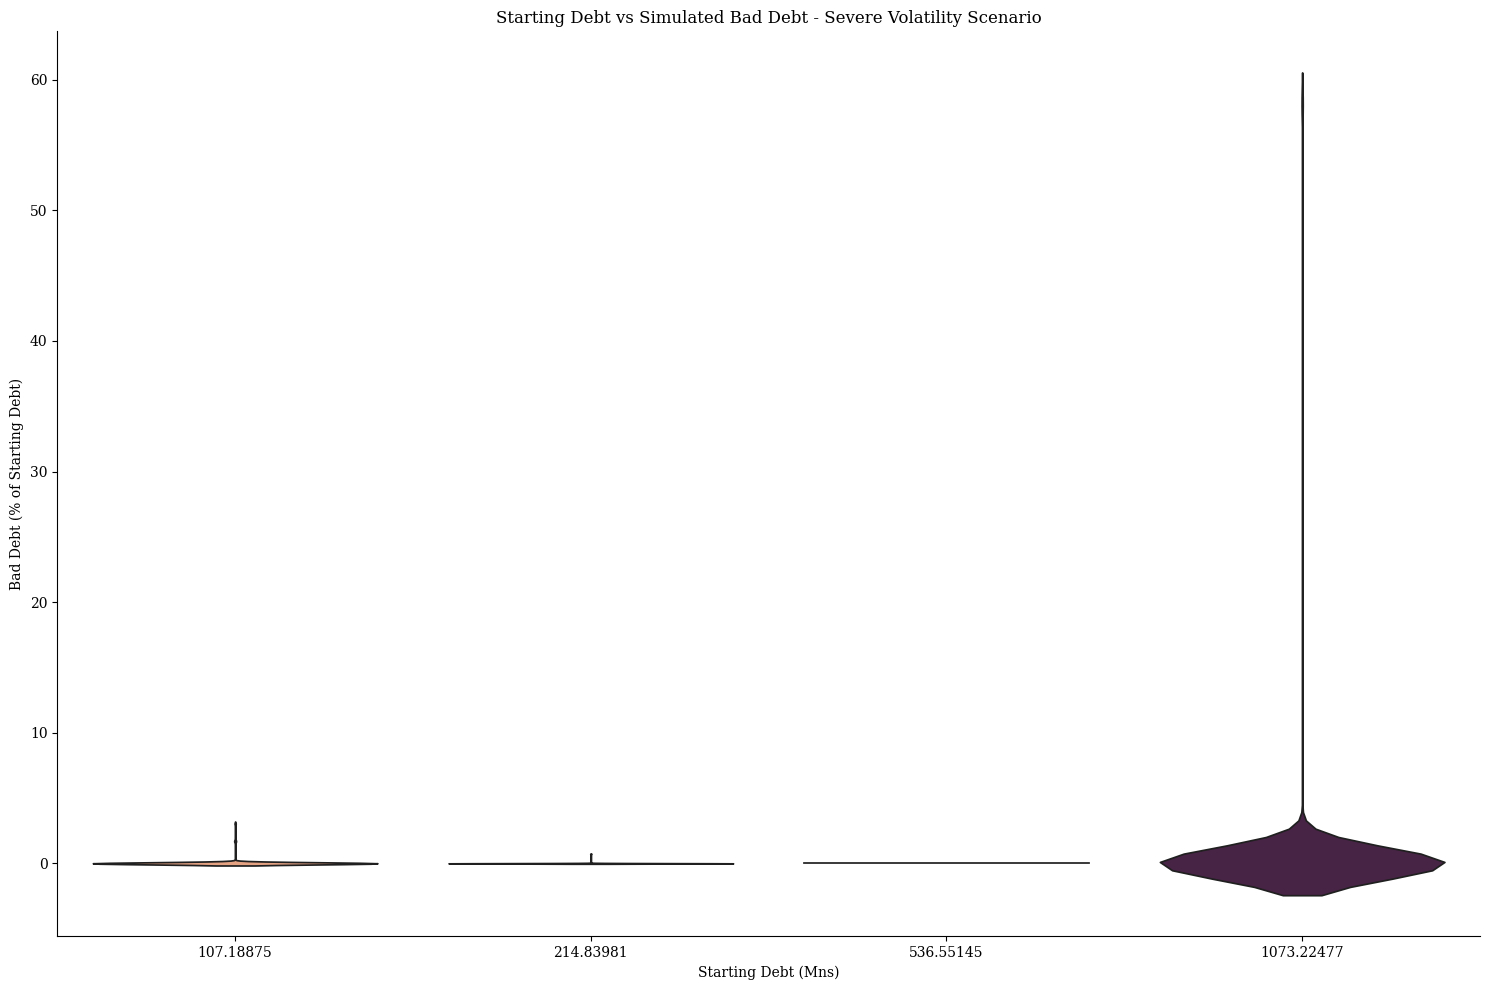

In [444]:
metrics = [
    # "Bad Debt Pct On Controller Wbtc",
    # "Bad Debt Pct On Controller Weth",
    "Bad Debt Pct On Controller Sfrxeth",
    # "Bad Debt Pct On Controller Wsteth",
]
df = compare(results, metrics)

### Zoom in
ndf = df.copy()
shock_fixes = {
    VOL: SEVERE,
    # MU: NEUTRAL,
    # JUMP: NEUTRAL,
    # LIQUIDITY: ADVERSE,
    DEBT: NEUTRAL,
}
for col, tag in shock_fixes.items():
    ndf = ndf[ndf[col] == tag]
ndf.sort_values(["Starting Debt (Mns)"], inplace=True)

idxs = ndf.index
nresults = [results[i] for i in idxs]
labels = ndf["Starting Debt (Mns)"]

bad_debts = [
    nresult.summary["Bad Debt Pct On Controller Sfrxeth Max"].tolist()
    for nresult in nresults
]

plt.figure(figsize=(15, 10))
sns.violinplot(data=bad_debts, palette="rocket_r", inner=None)
plt.xlabel("Starting Debt (Mns)")
plt.xticks(range(len(labels)), labels)
plt.ylabel("Bad Debt (% of Starting Debt)")
plt.title("Starting Debt vs Simulated Bad Debt - Severe Volatility Scenario")
plt.tight_layout()
plt.savefig("../figs/results/bad_debt_vs_starting_debt.png", dpi=300)
plt.show()

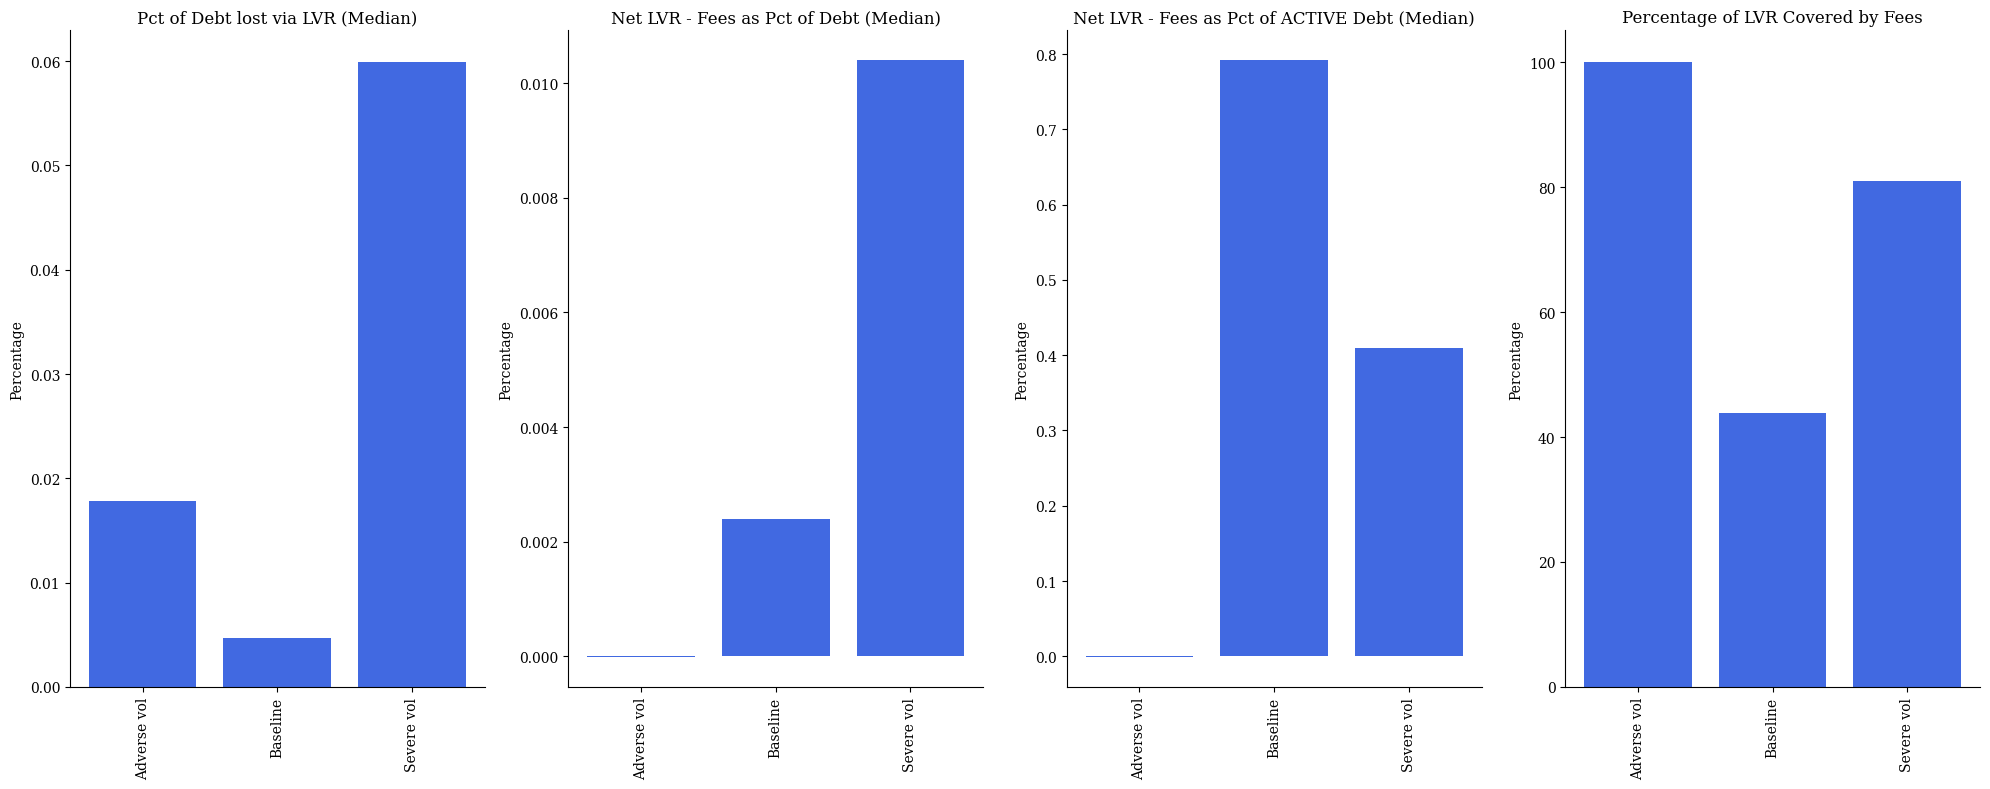

In [414]:
df = compare(results, include_lvr_metrics=True)

ndf = df.copy()
param_fixes = {
    "Value": 1,
}
for col, tag in param_fixes.items():
    ndf = ndf[ndf[col] == tag]
shock_fixes = {
    # VOL: SEVERE,
    # MU: NEUTRAL,
    # JUMP: NEUTRAL,
    # LIQUIDITY: ADVERSE,
    DEBT: NEUTRAL,
}
for col, tag in shock_fixes.items():
    ndf = ndf[ndf[col] == tag]

ndf.sort_values(["Name"], inplace=True)

f, axs = plt.subplots(1, 4, figsize=(20, 8))

ax = axs[0]
ax.bar(ndf["Name"], ndf["Soft Liquidation Loss Pct Median"], color="royalblue")
ax.set_title("Pct of Debt lost via LVR (Median)")
ax.set_ylabel("Percentage")
ax.tick_params(axis="x", rotation=90)

ax = axs[1]
ax.bar(ndf["Name"], ndf["Net LVR - Fees Pct Median"], color="royalblue")
ax.set_title("Net LVR - Fees as Pct of Debt (Median)")
ax.set_ylabel("Percentage")
ax.tick_params(axis="x", rotation=90)

ax = axs[2]
ax.bar(
    ndf["Name"],
    ndf["Net LVR - Fees Pct Median"] / (ndf["Active Debt Pct Median"] / 100),
    color="royalblue",
)
ax.set_title("Net LVR - Fees as Pct of ACTIVE Debt (Median)")
ax.set_ylabel("Percentage")
ax.tick_params(axis="x", rotation=90)

ax = axs[3]
ax.bar(ndf["Name"], ndf["Pct of LVR Covered by Fees Median"], color="royalblue")
ax.set_title("Percentage of LVR Covered by Fees")
ax.set_ylabel("Percentage")
ax.tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.savefig("../figs/results/fees_lvr_pct.png", dpi=300)
plt.show()

In [379]:
ndf

,Name,Parameter,Value,Starting Debt (Mns),Total crvUSD Liquidity (Mns),Starting Debt:Liquidity Ratio,mu,vol,jump,debt,liquidity,Bad Debt Pct Mean,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Mean,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Net Llamma Profit Pct Mean,Net Llamma Profit Pct Median,Net Llamma Profit Pct p99,Soft Liquidation Loss Pct Mean,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Borrower Loss Pct Mean,Borrower Loss Pct Median,Borrower Loss Pct p99,Worst Oracle Error Pct Mean,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99,Pct of LVR Covered by Fees Mean,Pct of LVR Covered by Fees Median,Pct of LVR Covered by Fees p01,Net LVR - Fees Pct Mean,Net LVR - Fees Pct Median,Net LVR - Fees Pct p01,Active Debt Pct Mean,Active Debt Pct Median
14,Adverse vol,debt_ceiling,1.0,108.098,47.693,2.267,neutral,adverse,neutral,neutral,neutral,0.004,0.0,0.146,0.574,0.176,7.919,0.036,0.017,0.223,0.039,0.018,0.248,0.085,0.037,0.842,0.159,0.150,0.204,96.563,100.092,40.207,0.003,-0.000,-0.032,2.100,1.075
11,Baseline,debt_ceiling,1.0,108.256,47.729,2.268,neutral,neutral,neutral,neutral,neutral,0.000,0.0,0.000,0.000,0.000,0.000,0.004,0.002,0.029,0.012,0.005,0.143,0.012,0.005,0.143,0.122,0.119,0.175,51.640,43.888,15.378,0.007,0.002,-0.002,0.654,0.302
13,Severe vol,debt_ceiling,1.0,107.189,47.849,2.240,neutral,severe,neutral,neutral,neutral,0.053,0.0,1.121,2.432,1.262,17.970,0.071,0.050,0.357,0.092,0.060,0.454,0.287,0.169,2.028,0.168,0.120,0.200,79.068,80.952,39.297,0.021,0.010,-0.002,4.058,2.536


In [408]:
# change these
i = 13
pct_active_debt = df.iloc[i]["Active Debt Pct Median"] / 100
net_lvr_minus_fees_pct = -df.iloc[i]["Net LVR - Fees Pct Median"] / 100


annual_r = annualize(net_lvr_minus_fees_pct / pct_active_debt)
print(f"Annual rate: {annual_r:.2f}%")

Annual rate: -77.69%
